In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import string
import time
import os
import pickle
import tqdm
import io
from wordcloud import WordCloud
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping
from typing import List, Optional

In [ ]:
pd.set_option("display.max_colwidth", None)
from keras.layers import LSTM, GRU, SimpleRNN
from IPython.display import Markdown
def bold(string):
    display(Markdown("**" + string + "**"))
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
try:
    df_ = pd.read_excel('/content/drive/MyDrive/Dataset/Global_Dataset.xlsx', usecols=['DESCRIPTION','SEVERITY'])
    df = df_.copy()
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
import io

def bold(text):
    print(f"\033[1m{text}\033[0m")

def print_stats(data):
    bold("#" * 50 + " SHAPE " + "#" * 50)
    print(f"ROWS: {data.shape[0]}")
    print(f"COLS: {data.shape[1]}")

    bold("#" * 50 + " TYPES " + "#" * 50)
    print(data.dtypes)

    bold("#" * 50 + " MISSING VALUES " + "#" * 50)
    print(data.isnull().sum())

    bold("#" * 50 + " DUPLICATED VALUES " + "#" * 50)
    print(f"NUMBER OF DUPLICATED VALUES: {data.duplicated().sum()}")

    bold("#" * 50 + " MEMORY USAGE " + "#" * 50)
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print(f"Memory Usage: {info}")


In [ ]:
df = df.dropna()


In [ ]:
df = df[df["SEVERITY"] != 'None']

In [ ]:
smart_words = "/content/drive/MyDrive/helping_materials/SmartStoplist.txt"
smart_stoplist = []
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [ ]:
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
def clean(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in smart_stoplist])
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

In [ ]:
df["CLEAN"] = df["DESCRIPTION"].apply(clean)


In [ ]:
le = LabelEncoder().fit(df["SEVERITY"])
le_nm = dict(zip(le.classes_, le.transform(le.classes_)))
df["LABELS"] = df["SEVERITY"].apply(lambda x: le_nm[x])
ndf = df.drop(["DESCRIPTION", "SEVERITY"], axis=1)

In [ ]:
X = ndf["CLEAN"]
y = ndf["LABELS"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [ ]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [ ]:
tokenizer = Tokenizer(num_words=400000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ")
tokenizer.fit_on_texts(X)

In [ ]:
word_index = tokenizer.word_index
len(word_index)
maxlen = 70

In [ ]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [ ]:
input_dim = len(tokenizer.word_index) + 1
input_dim

141133

Epoch 1/25
477/477 ━━━━━━━━━━━━━━━━━━━━ 238s 377ms/step - accuracy: 0.2621 - loss: 1.8752 - precision_1: 0.2687 - recall_1: 0.1209 - val_accuracy: 0.2424 - val_loss: 1.3476 - val_precision_1: 0.2401 - val_recall_1: 0.0282 - learning_rate: 5.0000e-04
Epoch 2/25
477/477 ━━━━━━━━━━━━━━━━━━━━ 182s 277ms/step - accuracy: 0.3767 - loss: 1.2549 - precision_1: 0.3779 - recall_1: 0.1186 - val_accuracy: 0.5399 - val_loss: 1.1433 - val_precision_1: 0.5865 - val_recall_1: 0.2371 - learning_rate: 5.0000e-04
Epoch 3/25
477/477 ━━━━━━━━━━━━━━━━━━━━ 128s 268ms/step - accuracy: 0.6406 - loss: 0.9039 - precision_1: 0.6986 - recall_1: 0.4050 - val_accuracy: 0.6211 - val_loss: 1.0250 - val_precision_1: 0.6747 - val_recall_1: 0.4888 - learning_rate: 5.0000e-04
Epoch 4/25
477/477 ━━━━━━━━━━━━━━━━━━━━ 142s 268ms/step - accuracy: 0.8004 - loss: 0.7016 - precision_1: 0.8457 - recall_1: 0.6999 - val_accuracy: 0.6859 - val_loss: 0.9398 - val_precision_1: 0.7144 - val_recall_1: 0.6399 - learning_rate: 5.0000e-04


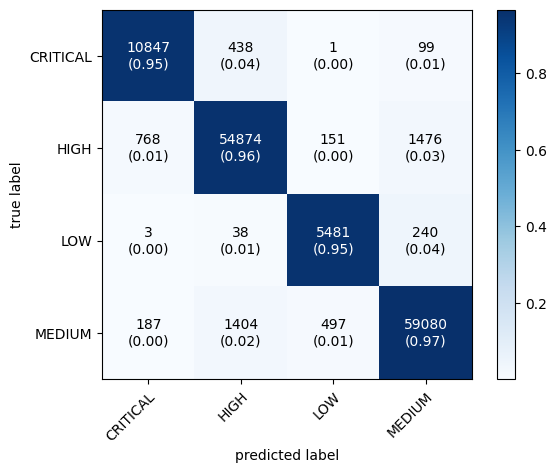

In [ ]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling2D, Dropout, BatchNormalization, Reshape, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Input layer for tokenized data
input_layer = Input(shape=(maxlen,))

# Embedding layer with increased dimensions
embedding_layer = Embedding(len(tokenizer.word_index) + 1, 128, trainable=True)(input_layer)

# Reshape embedding to add a spatial dimension (necessary for DenseNet input)
reshaped_embedding = Reshape((maxlen, 128, 1))(embedding_layer)

# Convert single channel to three channels to match DenseNet's input expectations
reshaped_embedding = BatchNormalization()(reshaped_embedding)
reshaped_embedding = Concatenate()([reshaped_embedding] * 3)  # Duplicate channels

# Load pre-trained DenseNet169 with adjusted input dimensions
densenet = DenseNet169(
    include_top=False,
    weights='imagenet',
    input_shape=(maxlen, 128, 3),
    pooling='max'
)

# Unfreeze last 50 layers for fine-tuning
for layer in densenet.layers[:-75]:
    layer.trainable = False

# Apply DenseNet to the reshaped embedding
x = densenet(reshaped_embedding)

# Additional dense layers
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer with label smoothing
output_layer = Dense(4, activation='softmax')(x)

# Create the model
advanced_densenet_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with Adam optimizer and label smoothing
optimizer = Adam(learning_rate=0.0005)
advanced_densenet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=optimizer,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model
advanced_densenet_results = advanced_densenet_model.fit(
    X_train_tokenizer,
    tf.keras.utils.to_categorical(y_train),
    epochs=25,
    batch_size=256,
    validation_split=0.1,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, early_stopping]
)

# Predict on test data
advanced_densenet_pred_test = advanced_densenet_model.predict(X_test_tokenizer)
advanced_densenet_pred_train = advanced_densenet_model.predict(X_train_tokenizer)

# Convert predictions to class labels
advanced_densenet_pred_train = np.argmax(advanced_densenet_pred_train, axis=1)
advanced_densenet_pred_test = np.argmax(advanced_densenet_pred_test, axis=1)

# Classification report
print(classification_report(y_train, advanced_densenet_pred_train, target_names=le.classes_))

# Confusion matrix
advanced_densenet_cm = confusion_matrix(y_train, advanced_densenet_pred_train)
fig, ax = plot_confusion_matrix(conf_mat=advanced_densenet_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=le.classes_)
plt.show()



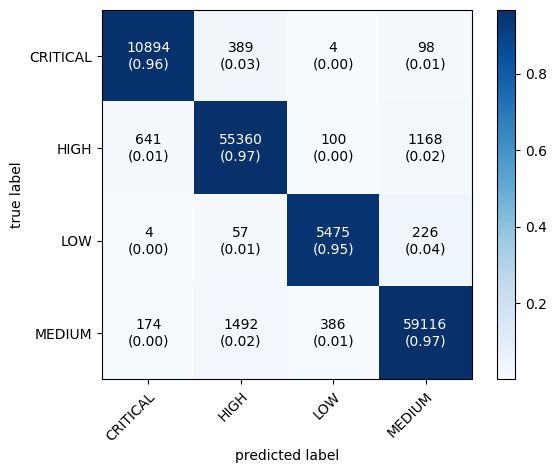

In [ ]:
advanced_densenet_cm = confusion_matrix(y_train, advanced_densenet_pred_train)
fig, ax = plot_confusion_matrix(conf_mat=advanced_densenet_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=le.classes_)
plt.show()